# Network anomaly detection

Multiclass classification model to predict network anomolies

- Feb 2021
- Domino Valdano and Frank McQuillan

## Summary

Our primary focus in this project was preprocessing and feature selection, rather than trying many different supervised learning algorithms.  We landed here after working with the data for some time and trying to understand it in depth. Initial trys indicated that, for example, small differences in sampling methodologies resulted in very different accuracies on the validation dataset.  This is, we suppose, the nature of this type of severely imbalanced problem.

In the end we found that oversampling minority classes and undersampling majority classes in a relatively simple way resulted in reasonable accuracy.  However, oversampling minority classes by duplication tends to result in overfitting, as we typically achieved greater than 90% accuracy on both test/train splits, but only 60-something% on the public leaderboard. SMOTE-type approaches [1,2] were tried at for oversampling but did not figure in our final submission.

## Preprocessing and feature selection

Started by plotting histograms to look at the nature of the data skew.  Used data summarization methods to look at descriptive statistics like correlation.  Tried clustering to see if decision boundaries were clean (they are not).  Then use oversampling minority classes and undersampling majority classes to generate the data to feed to the random forest model. 

## Training methodology

We used a random forest with the following parameters:

            10::integer,              -- num trees
            5::integer,               -- num random features
            5::integer,               -- num permutations
            10::integer,              -- max tree depth
            3::integer,               -- min split
            1::integer,               -- min bucket
            10::integer,              -- num splits
            
We kept this constant while we experimented with sampling approaches.  Random forest is commonly used on anomaly detection problems [3] and also has the benefit of not requiring 1-hot encoding or normalization/standardization.  At least, normalization/standardization is less important in tree methods than other supervised learning methods.

## Notable aspects

Keep it simple.  Don't try to reverse engineer rules-based approaches since that is very time consuming and you will likely miss something important.  Many of our laptop based Python methods had memory issues (e.g., with SMOTENC) so we found working in an MPP database very convenient, since ~5M examples is pretty small in MPP land.  So we used Greenplum with Apache MADlib for most of the heavy lifting.

But most of all, we had fun trying things out!

## References

[1] SMOTE for Imbalanced Classification with Python
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

[2] SMOTE algorithms
https://imbalanced-learn.org/stable/references/over_sampling.html#smote-algorithms

[3] Anomaly detection using random forest: A performance revisited https://ieeexplore.ieee.org/document/8285847

## Inline code comments

Please see notebook below.

### Setup 

* <a href="#dependencies">Dependencies</a>
* <a href="#package_options">Package Options</a>
* <a href="#database_connection">Database Connection</a>
    
    
### Data Loading

* <a href="#download_data">Download Data and View Sample</a>


### Data Exploration

* <a href="#summary_statistics">Summary Statistics</a>
* <a href="#de_categorical">Categorical Columns</a>
* <a href="#de_continuous">Continuous Columns</a>
* <a href="#fe_corr">Correlation Testing</a>
* <a href="#cluster">Clustering</a>

### Feature Engineering

* <a href="#feature_eng">Sampling and feature engineering</a>


### Model Development

* <a href="#train_vali_split">Training & Validation Sample Split</a>


* **Random Forest (MADlib)**
    * <a href="#rf_train_model">Train model</a>
    * <a href="#rf_variable_importance">Variable Importance</a>
    * <a href="#rf_score_out_of_sample">Score Validation Data</a>
    * <a href="#confusion">Confusion Matrix</a>

### Write out results

* <a href="#write">CSV output</a>

----


## Setup

Create database connection and import libraries

<a id="dependencies"></a>

In [1]:
%load_ext sql

In [2]:
# Greenplum Database 5.x on GCP (PM demo machine) - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

In [3]:
# dependencies
import psycopg2               # Python-PostgreSQL Database Adapter - https://pypi.python.org/pypi/psycopg2
import pandas as pd           # Python Data Analysis Library - https://pandas.pydata.org/
import seaborn as sns         # Statistical data visualization - https://seaborn.pydata.org/
import math                   # Mathematical functions - https://docs.python.org/2/library/math.html
import textwrap as tw         # Text wrapping and filling - https://docs.python.org/2/library/textwrap.html
import ipywidgets as widgets  # Jupyter Widgets - https://ipywidgets.readthedocs.io/en/latest/
import IPython.display as ipd # http://ipython.org/documentation.html

<a id="package_options"></a>

In [4]:
# package options
# %matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (12, 8)
    
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_colwidth', -1)

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


<a id="database_connection"></a>

In [5]:
# init to default values
database_host = 'localhost'
database_databasename = 'madlib'
database_username = 'gpadmin'
database_password = ''
database_port = '8000'

# interpret string as markdown
def printmd(string):
    ipd.display(ipd.Markdown(string))
    
# forms
message = "### Connection Details \n ------"
printmd(message)
    
printmd("**Host:**")
inputHost = widgets.Text()
ipd.display(inputHost)

printmd("**Port:**")
inputPort = widgets.Text()
ipd.display(inputPort)

printmd("**Database Name:**")
inputDatabaseName = widgets.Text()
ipd.display(inputDatabaseName)

printmd("**Username:**")
inputUsername = widgets.Text()
ipd.display(inputUsername)

printmd("**Password:**")
inputPassword = widgets.Text()
ipd.display(inputPassword)

printmd("*Leave blank for default values*")


def db_connect():
    global conn, cur
    try:
        connString = "host='{}' dbname='{}' user='{}' password='{}' port={}".format(database_host,database_databasename,database_username,database_password,database_port)
        # print connString
        conn = psycopg2.connect(connString)
        cur = conn.cursor()
        conn.autocommit = True
        message = "<span style='color:green'>**Connection successful!**</span>"
        printmd(message)
    except:
        message = "<span style='color:red'>**ERROR: Unable to connect to the database**</span>"
        printmd(message)
    
def on_button_click(b):
    
    global database_host, database_databasename, database_username, database_password, database_port
    
    ipd.clear_output()
    
    message = "### Connection Details \n ------"
    printmd(message)
    
    if inputHost.value == "":
        message = "**Host:** {} (default)".format(database_host)
        printmd(message)
    else:
        database_host = inputHost.value
        message = "**Host:** {}".format(database_host)
        printmd(message)

    if inputPort.value == "":
        message = "**Port:** {} (default)".format(database_port)
        printmd(message)
    else:
        database_port = inputPort.value
        message = "**Port:** {}".format(database_port)
        printmd(message)
        
    if inputDatabaseName.value == "":
        message = "**Database name:** {} (default)".format(database_databasename)
        printmd(message)
    else:
        database_databasename = inputDatabaseName.value
        message = "**Database name:** {}".format(database_databasename)
        printmd(message)
        
    if inputUsername.value == "":
        message = "**Username:** {} (default)".format(database_username)
        printmd(message)
    else:
        database_username = inputUsername.value
        message = "**Username:** {}".format(database_username)
        printmd(message)
        
    if inputPassword.value == "":
        message = "**Password:** {} (default)".format(database_password)
        printmd(message)
    else:
        database_password = inputPassword.value
        message = "**Password:** ###########"
        printmd(message)
    
    printmd("------")
    db_connect()
        
button = widgets.Button(description="Connect")
ipd.display(button)
button.on_click(on_button_click)

### Connection Details 
 ------

**Host:** localhost

**Port:** 8000

**Database name:** madlib

**Username:** gpadmin

**Password:**  (default)

------

<span style='color:green'>**Connection successful!**</span>

In [7]:
def bar_plot(data,title,x,xLabel,y,yLabel,color=None,xAxisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color)
    else:
        plt = sns.barplot(x=x, y=y, data=data)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=12)
    plt.set_ylabel(yLabel,fontsize=12)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(xAxisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')


In [8]:
database_host = 'localhost'
database_databasename = 'madlib'
database_username = 'gpadmin'
database_password = ''
database_port = '8000'
db_connect()

<span style='color:green'>**Connection successful!**</span>

In [9]:
# helper function
def query_gpdb(query): 

    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)

In [8]:
%sql SET search_path=public,madlib

Done.


[]

<a id="download_data"></a>

## Data Loading

Training dataset

In [ ]:
%%sql
DROP TABLE IF EXISTS training_data;
CREATE TABLE training_data (
    a1 TEXT,
    a2 TEXT,
    a3 TEXT,
    a4 FLOAT,
    a5 FLOAT,
    a6 INTEGER,
    a7 INTEGER,
    a8 INTEGER,
    a9 INTEGER,
    a10 INTEGER,
    a11 INTEGER,
    a12 FLOAT,
    a13 FLOAT,
    a14 FLOAT,
    a15 INTEGER,
    a16 FLOAT,
    a17 FLOAT,
    a18 FLOAT,
    a19 FLOAT,
    a20 FLOAT,
    a21 FLOAT,
    a22 FLOAT,
    a23 FLOAT,
    a24 INTEGER,
    a25 FLOAT,
    a26 FLOAT,
    a27 FLOAT,
    a28 FLOAT,
    a29 FLOAT,
    a30 FLOAT,
    a31 FLOAT,
    a32 FLOAT,
    a33 FLOAT,
    a34 FLOAT,
    a35 FLOAT,
    a36 FLOAT,
    a37 FLOAT,
    a38 FLOAT,
    a39 FLOAT,
    a40 FLOAT,
    a41 FLOAT,
    a42 INTEGER,
    y TEXT
);

COPY training_data FROM '/home/gpadmin/network_data/training.csv' CSV DELIMITER ',';

Add row number to training data

In [13]:
%%sql
DROP TABLE IF EXISTS training_data_id;
CREATE TABLE training_data_id AS
SELECT ROW_NUMBER() OVER()-1 AS id, * FROM training_data;

Done.
4898431 rows affected.


[]

In [14]:
%%sql
DROP TABLE training_data;
ALTER TABLE training_data_id RENAME TO training_data;

Done.
Done.


[]

Have a look at some sample data

In [15]:
%%sql
SELECT * FROM training_data ORDER BY id LIMIT 5;

5 rows affected.


id,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,y
0,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1397.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0,class18
1,TCP,PRIVATE,STAT06,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.08,0,1253.0,0.0,0.0,0.08,9.0,0.0,0.0,11.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.04,0.0,255.0,0.0,0.0,0.06,1.0,116.0,1.0,0,class10
2,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1052.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0,class18
3,TCP,PRIVATE,STAT06,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.01,0,996.0,0.0,0.0,0.07,1.0,0.0,0.0,6.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.02,0.0,255.0,0.0,0.0,0.07,1.0,199.0,1.0,0,class10
4,UDP,NTP_U,STAT10,48.0,48.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1082.0,0.31,0.0,0.08,1.0,0.0,0.0,8.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,26.0,0.0,0.0,0.0,0.0,1.0,0.0,0,normal


In [10]:
%%sql
SELECT COUNT(*) FROM training_data;

1 rows affected.


count
4898431


Evaluation dataset

In [ ]:
%%sql
DROP TABLE IF EXISTS eval_data;
CREATE TABLE eval_data (
    id INTEGER,
    a1 TEXT,
    a2 TEXT,
    a3 TEXT,
    a4 FLOAT,
    a5 FLOAT,
    a6 INTEGER,
    a7 INTEGER,
    a8 INTEGER,
    a9 INTEGER,
    a10 INTEGER,
    a11 INTEGER,
    a12 FLOAT,
    a13 FLOAT,
    a14 FLOAT,
    a15 INTEGER,
    a16 FLOAT,
    a17 FLOAT,
    a18 FLOAT,
    a19 FLOAT,
    a20 FLOAT,
    a21 FLOAT,
    a22 FLOAT,
    a23 FLOAT,
    a24 INTEGER,
    a25 FLOAT,
    a26 FLOAT,
    a27 FLOAT,
    a28 FLOAT,
    a29 FLOAT,
    a30 FLOAT,
    a31 FLOAT,
    a32 FLOAT,
    a33 FLOAT,
    a34 FLOAT,
    a35 FLOAT,
    a36 FLOAT,
    a37 FLOAT,
    a38 FLOAT,
    a39 FLOAT,
    a40 FLOAT,
    a41 FLOAT,
    a42 INTEGER
);

COPY eval_data FROM '/home/gpadmin/network_data/eval-rev2-1.csv' DELIMITER ',' CSV HEADER;

Have a look at some rows from the eval dataset

In [11]:
%%sql
SELECT * FROM eval_data ORDER BY id LIMIT 5;

5 rows affected.


id,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42
0,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1328.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0
1,TCP,HTTP,STAT10,280.0,3413.0,0,0,0,0,1,0,0.0,0.0,1.0,0,674.0,0.04,0.0,0.0,26.0,0.0,0.0,251.0,0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,1.0,0.0,26.0,0.0,0.0,0.0,0.0,26.0,0.0,0
2,TCP,HTTP,STAT10,218.0,1493.0,0,0,0,0,1,0,0.0,0.0,1.0,0,990.0,0.01,0.0,0.0,9.0,0.0,0.0,255.0,0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,129.0,0.0,0.0,0.0,0.0,9.0,0.0,0
3,ICMP,ECR_I,STAT10,520.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1178.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0
4,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1554.0,1.0,0.0,0.0,510.0,0.0,0.0,255.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,510.0,0.0,0


In [12]:
%%sql
SELECT COUNT(*) FROM eval_data;

1 rows affected.


count
311030


## Data Exploration

Frequency histogram

In [48]:
%%sql
SELECT y, class_count, (class_count/SUM(class_count) OVER ()) AS percent
FROM 
(
SELECT y, COUNT(*) AS class_count FROM training_data GROUP BY y
) q ORDER BY percent DESC;

23 rows affected.


y,class_count,percent
class18,2807886,0.57322150704991047133
class10,1072017,0.21884905595281427869
normal,972781,0.19859032412623552317
class17,15892,0.00324430414555191244
class06,12481,0.00254795872392608980
class15,10413,0.00212578272512157464
class11,2316,0.00047280445514084000
class01,2203,0.00044973584398759521
class21,1020,0.00020822994138327150
class20,979,0.00019985991432766941


So, this is an extremely unbalanced dataset!

<a id="summary_statistics"></a>
### Summary Deterministic Statistics

https://madlib.apache.org/docs/latest/group__grp__summary.html

In [ ]:
%%sql
DROP TABLE IF EXISTS training_summary;
SELECT * FROM madlib.summary( 'training_data',   -- Source table
                              'training_summary'    -- Output table
                            );

In [17]:
%%sql
SELECT * FROM training_summary;

43 rows affected.


group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
None,None,a1,1,text,4898431,3,0,0,0.0,0.0,None,None,None,None,None,None,3.0,4.0,None,None,None,"[u'ICMP', u'TCP', u'UDP']","[2833545L, 1870598L, 194288L]"
None,None,a2,2,text,4898431,70,0,0,0.0,0.0,None,None,None,None,None,None,3.0,11.0,None,None,None,"[u'ECR_I', u'PRIVATE', u'HTTP', u'SMTP', u'OTHER', u'DOMAIN_U', u'FTP_DATA', u'ECO_I', u'FINGER', u'URP_I']","[2811660L, 1100745L, 623078L, 96530L, 72647L, 57782L, 40689L, 16338L, 6904L, 5378L]"
None,None,a3,3,text,4898431,11,0,0,0.0,0.0,None,None,None,None,None,None,6.0,6.0,None,None,None,"[u'STAT10', u'STAT06', u'STAT02', u'STAT05', u'STAT03', u'STAT11', u'STAT07', u'STAT08', u'STAT04', u'STAT01']","[3744328L, 840347L, 297625L, 8094L, 6075L, 1040L, 532L, 161L, 122L, 57L]"
None,None,a4,4,float8,4898431,7195,0,None,0.0,None,3745885,0,1152546,1832.10418316,8.86292473314e+11,"[998.392083442931, 2665.81628286865]",0.0,1379963888.0,45.0,520.0,1032.0,"[u'1032', u'0', u'520', u'105', u'147', u'146', u'42', u'8', u'44', u'145']","[2255724L, 1152559L, 545377L, 73912L, 27348L, 20378L, 10755L, 10529L, 9236L, 9224L]"
None,None,a5,5,float8,4898431,22788,0,None,0.0,None,833577,0,4064854,1093.62281371,4.1604091068e+11,"[522.41308836093, 1664.83253906548]",0.0,1309937401.0,0.0,0.0,0.0,"[u'0', u'105', u'147', u'146', u'145', u'42', u'330', u'329', u'331', u'332']","[4065027L, 44906L, 25045L, 22935L, 9632L, 9410L, 8425L, 7908L, 7886L, 7415L]"
None,None,a6,6,int4,4898431,2,0,None,0.0,None,4091,0,4894340,0.000835165382548,0.000834468051686,"[0.000809583504108748, 0.00086074726098726]",0.0,1.0,0.0,0.0,0.0,"[u'0', u'1']","[4894340L, 4091L]"
None,None,a7,7,int4,4898431,2,0,None,0.0,None,2,0,4898429,4.08294002712e-07,4.0829391936e-07,"[-1.57572557277603e-07, 9.74160562702197e-07]",0.0,1.0,0.0,0.0,0.0,"[u'0', u'1']","[4898429L, 2L]"
None,None,a8,8,int4,4898431,3,0,None,0.0,None,110,0,4898321,3.67464602441e-05,6.53257034677e-05,"[2.95888240326134e-05, 4.39040964556e-05]",0.0,2.0,0.0,0.0,0.0,"[u'0', u'2', u'1']","[4898321L, 70L, 40L]"
None,None,a9,9,int4,4898431,2,0,None,0.0,None,334,0,4898097,6.8185098453e-05,6.81804631641e-05,"[6.08727387362456e-05, 7.54974581696616e-05]",0.0,1.0,0.0,0.0,0.0,"[u'0', u'1']","[4898097L, 334L]"
None,None,a10,10,int4,4898431,2,0,None,0.0,None,703067,0,4195364,0.143529019802,0.122928465372,"[0.143218525379488, 0.143839514225438]",0.0,1.0,0.0,0.0,0.0,"[u'0', u'1']","[4195364L, 703067L]"


In [ ]:
%%sql
DROP TABLE IF EXISTS eval_summary;
SELECT * FROM madlib.summary( 'eval_data',   -- Source table
                              'eval_summary'    -- Output table
                            );

In [18]:
%%sql
SELECT * FROM eval_summary;

43 rows affected.


group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
None,None,id,1,int4,311030,311030,0,None,0.0,None,311029,0,1,155514.5,8061664327.5,"[155198.950652354, 155830.049347646]",0.0,311029.0,77757.25,155514.5,233271.75,"[u'309391', u'310604', u'309912', u'308013', u'309815', u'309166', u'308033', u'310099', u'310125', u'310262']","[305L, 304L, 303L, 296L, 296L, 296L, 295L, 294L, 293L, 293L]"
None,None,a1,2,text,311030,3,0,0,0.0,0.0,None,None,None,None,None,None,3.0,4.0,None,None,None,"[u'ICMP', u'TCP', u'UDP']","[164969L, 119358L, 26703L]"
None,None,a2,3,text,311030,65,0,0,0.0,0.0,None,None,None,None,None,None,3.0,11.0,None,None,None,"[u'ECR_I', u'PRIVATE', u'HTTP', u'SMTP', u'POP_3', u'DOMAIN_U', u'FTP_DATA', u'OTHER', u'TELNET', u'FTP']","[164352L, 78596L, 41250L, 8292L, 3990L, 3160L, 2231L, 2191L, 1978L, 834L]"
None,None,a3,4,text,311030,11,0,0,0.0,0.0,None,None,None,None,None,None,6.0,6.0,None,None,None,"[u'STAT10', u'STAT06', u'STAT02', u'STAT05', u'STAT03', u'STAT09', u'STAT11', u'STAT07', u'STAT08', u'STAT01']","[248379L, 47494L, 13194L, 872L, 663L, 289L, 84L, 27L, 22L, 4L]"
None,None,a4,5,float8,311030,2504,0,None,0.0,None,248127,0,62903,1771.34123718,16296111145.3,"[1322.70234433321, 2219.98013002618]",0.0,62825648.0,105.0,520.0,1032.0,"[u'1032', u'0', u'520', u'105', u'2599', u'30', u'44', u'54540', u'45', u'42']","[133149L, 62903L, 30947L, 19616L, 5001L, 2372L, 1169L, 1062L, 976L, 941L]"
None,None,a5,6,float8,311030,8906,0,None,0.0,None,75209,0,235821,747.992216185,259859352.891,"[691.339060289833, 804.645372080035]",0.0,5203179.0,0.0,0.0,0.0,"[u'0', u'146', u'147', u'293', u'93', u'105', u'44', u'8314', u'42', u'174']","[235828L, 8578L, 5570L, 5002L, 3620L, 1248L, 1078L, 1064L, 698L, 613L]"
None,None,a6,7,int4,311030,2,0,None,0.0,None,754,0,310276,0.00242420345304,0.00241833446591,"[0.00225137584714799, 0.00259703105893823]",0.0,1.0,0.0,0.0,0.0,"[u'0', u'1']","[310276L, 754L]"
None,None,a7,8,int4,311030,2,0,None,0.0,None,12,0,311018,3.85814873163e-05,3.8580122825e-05,"[1.67523418904946e-05, 6.04106327421774e-05]",0.0,1.0,0.0,0.0,0.0,"[u'0', u'1']","[311018L, 12L]"
None,None,a8,9,int4,311030,3,0,None,0.0,None,5,0,311025,2.25058676012e-05,3.53659705652e-05,"[1.60579851281076e-06, 4.34059366895812e-05]",0.0,2.0,0.0,0.0,0.0,"[u'0', u'1', u'2']","[311025L, 3L, 2L]"
None,None,a9,10,int4,311030,2,0,None,0.0,None,62,0,310968,0.000199337684468,0.000199298589725,"[0.000149723364405963, 0.000248952004529509]",0.0,1.0,0.0,0.0,0.0,"[u'0', u'1']","[310968L, 62L]"


Columns a4 and a5 have a range of 1.3-1.4B, way more than other columns.
Column a42 has all the same values so can be ignored.
Let's create a widget to look at indidual features:

<a id="de_categorical"></a>
#### Categorical Columns

-----
 **Select Column:**

RHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2x1bW46Jywgb3B0aW9ucz0oJ2ExJywgJ2EyJywgJ2EzJywgJ2E2JywgJ2E3JywgJ2E4JywgJ2E5JywgJ2ExMCcsICdhMTEnLCAnYTE1JywgJ2EyNCfigKY=


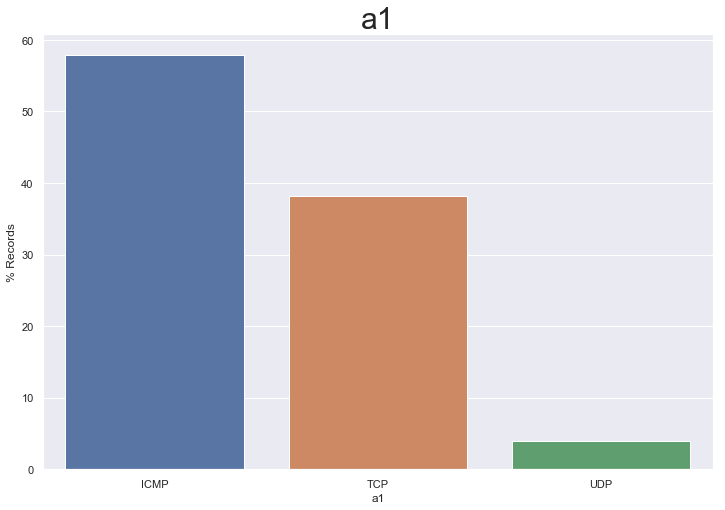

In [13]:
catColumns = ['a1','a2','a3', 'a6','a7','a8', 'a9',
              'a10','a11', 'a15','a24','a42',
              'y']

def bar_plot(data,title,x,xLabel,y,yLabel,color=None,xAxisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color)
    else:
        plt = sns.barplot(x=x, y=y, data=data)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=12)
    plt.set_ylabel(yLabel,fontsize=12)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(xAxisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')


def get_cat_data_frame(col):
    query = """
        SELECT *
              ,round((record_count * 100.0) / sum(record_count) OVER(),2) AS perc_records
        FROM (
            SELECT {} AS col
                  ,count(*) AS record_count
            FROM public.training_data
            GROUP BY 1
        ) foo
        ORDER BY perc_records DESC
    """.format(col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cat_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        ipd.clear_output()
        printmd("-----\n **Select Column:**")
        ipd.display(catDropdown)
        df = get_cat_data_frame(res['new'])
        bar_plot(df,res['new'],"col",res['new'],"perc_records","% Records", None, 0)
    
catDropdown = widgets.Dropdown(
    options=catColumns,
    value=catColumns[0],
    description='Column:',
    disabled=False,
)

catDropdown.observe(on_cat_selection)
printmd("-----\n **Select Column:**")
ipd.display(catDropdown)
df = get_cat_data_frame(catColumns[0])
bar_plot(df,catColumns[0],"col",catColumns[0],"perc_records","% Records", None, 0)

* Low % of values in any one class can skew model results and/or create unstable model.
* Histogram values are being calculated in the database - minimal data movement back to client

<a id="de_continuous"></a>
#### Continuous Columns

-----


SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2x1bW46JywgaW5kZXg9NSwgb3B0aW9ucz0oJ2E0JywgJ2E1JywgJ2ExMicsICdhMTMnLCAnYTE0JywgJ2ExNicsICdhMTfigKY=


-----


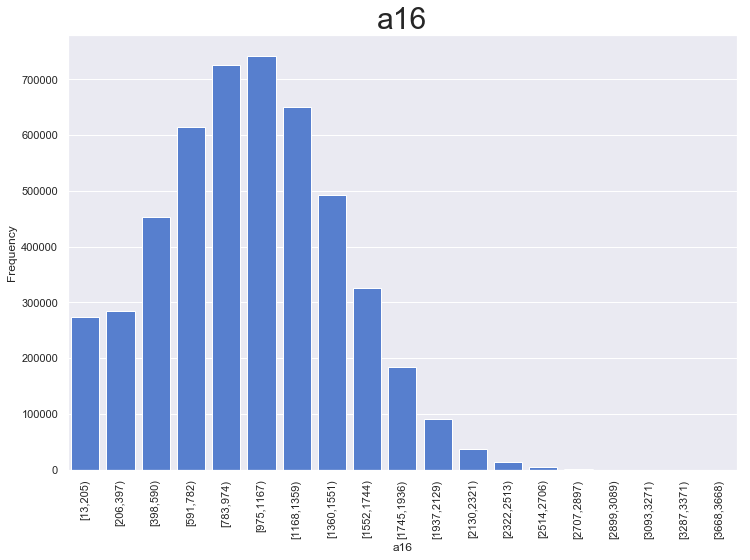

In [14]:
contColumns = ['a4', 'a5','a12', 'a13', 'a14', 'a16', 
               'a17', 'a18', 'a19', 'a20', 'a21', 
               'a22', 'a23', 'a25', 'a26', 'a27', 
               'a28', 'a29', 'a30', 'a31', 'a32', 
               'a33', 'a34', 'a35', 'a36', 'a37', 
               'a38', 'a39', 'a40', 'a41']
sliderValue = 20
colName = contColumns[0]

def get_cont_data_frame(col, buckets):
    query = """
        WITH aggs AS (
            SELECT min({c}) AS min,
                   max({c}) AS max
              FROM training_data
        )
        SELECT width_bucket({c}, min, max, {b}-1) AS bucket,
               ('[' || min({c}) || ',' || max({c}) || ')')::text as range,
               count(*) as freq
        FROM training_data, aggs
        GROUP BY bucket
        ORDER BY bucket
    """.format(c=col, b=buckets)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def graph_reset():
    ipd.clear_output()
    printmd("-----\n")
    ipd.display(widgets.HBox((contDropdown,bucketsSlider)))
    printmd("-----\n")
    df = get_cont_data_frame(colName,sliderValue)
    bar_plot(df,colName,"range",colName,"freq","Frequency", "#4378E2")    
    
def on_cont_selection(res):
    global colName
    if res['type'] == 'change' and res['name'] == 'value':
        colName = res['new']
        graph_reset()
        
def on_slider_selection(res):
    global sliderValue
    if res['new'] == {} and res['old']:
        sliderValue = res['old']['value']
        graph_reset()
    
# Look at log transforms
#colsAddLogs = contColumns + ["log({} + 1)".format(c) for c in contColumns]
colsAddLogs = contColumns

contDropdown = widgets.Dropdown(
    options=colsAddLogs,
    value=colsAddLogs[0],
    description='Column:',
    disabled=False,
)

bucketsSlider = widgets.IntSlider(
    value=sliderValue,
    min=5,
    max=50,
    step=1,
    description='# Buckets:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

contDropdown.observe(on_cont_selection)
bucketsSlider.observe(on_slider_selection)

graph_reset()



* Consider variable transformation if test non-tree based algorithm
* Histogram values are being calculated in the database - minimal data movement back to client

<a id="fe_corr"></a>
#### Correlation Testing

https://madlib.apache.org/docs/latest/group__grp__correlation.html

In [23]:
%%sql
DROP TABLE IF EXISTS public.feature_correlations, public.feature_correlations_summary;
SELECT madlib.correlation( 
        'public.training_data',
        'public.feature_correlations'
);

Done.
1 rows affected.


correlation
"Summary for 'Correlation' functionOutput table = public.feature_correlationsNon-numeric columns ignored: a1,a2,a3,yProducing correlation for columns: id,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42Total run time = ('public.feature_correlations', 40, 50.440470933914185)"


In [24]:
corr = %sql SELECT * FROM public.feature_correlations ORDER BY column_position;
corr = corr.DataFrame()
corr.drop('column_position', 'columns', inplace=True)
corr.set_index('variable', True, False, True)
corr

40 rows affected.


,id,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
id,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a4,-0.000906,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a5,0.000414,2.393421e-04,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a6,-0.000261,-3.600888e-05,0.000035,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a7,0.000551,-1.082987e-06,0.000004,-0.000018,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a8,0.000057,-4.110433e-06,0.001204,-0.000131,-2.905093e-06,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a9,0.000189,-5.598723e-06,0.000988,-0.000239,-5.276502e-06,0.455745,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a10,0.000052,2.009464e-04,0.002119,0.070524,1.560893e-03,0.011106,0.020172,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a11,0.000436,-4.652790e-06,-0.000004,-0.000069,-1.527701e-06,-0.000011,-0.000020,-0.000979,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


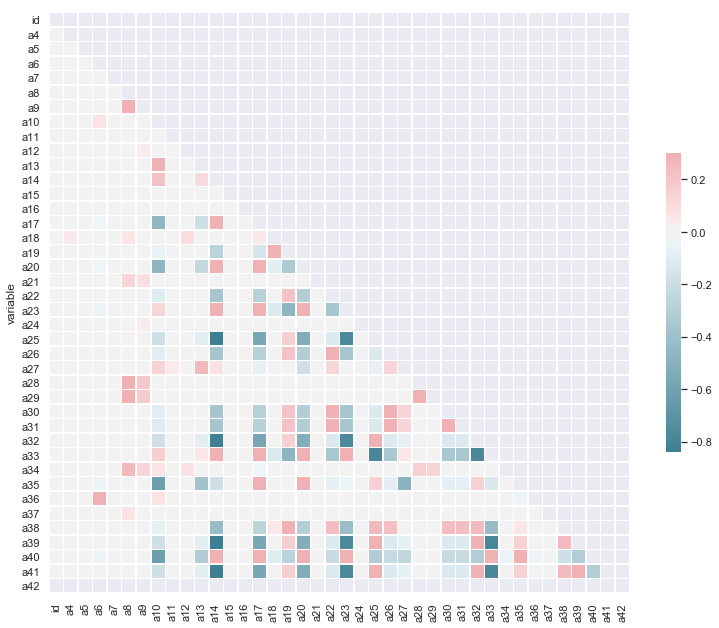

In [25]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))
f, ax = plt.subplots(figsize=(13, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False);

See mix of positive and negative correlations
- means complex interactions between features
- means can’t take a rule-based approach or try to data engineer/reverse engineer the feature interactions
- means PCA may be a candidate to try to reduce dimensionality of problem

<a id="cluster"></a>
### Clustering

Question:  how well do minority classes cluster?  This may tell us something about the sharpness of the decision boundary

First encode the text columns

In [ ]:
%%sql
DROP TABLE IF EXISTS training_data_encoded, training_data_encoded_dictionary;
SELECT madlib.encode_categorical_variables (
        'training_data',            -- Source table
        'training_data_encoded',      -- Output table
        'a1, a2, a3'                        -- Categorical columns
        );

In [49]:
%%sql
select * from training_data_encoded limit 5;

5 rows affected.


a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42,y,a1_icmp,a1_tcp,a1_udp,a2_aol,a2_auth,a2_bgp,a2_courier,a2_csnet_ns,a2_ctf,a2_daytime,a2_discard,a2_domain,a2_domain_u,a2_echo,a2_eco_i,a2_ecr_i,a2_efs,a2_exec,a2_finger,a2_ftp,a2_ftp_data,a2_gopher,a2_harvest,a2_hostnames,a2_http,a2_http_2784,a2_http_443,a2_http_8001,a2_imap4,a2_irc,a2_iso_tsap,a2_klogin,a2_kshell,a2_ldap,a2_link,a2_login,a2_mtp,a2_name,a2_netbios_dgm,a2_netbios_ns,a2_netbios_ssn,a2_netstat,a2_nnsp,a2_nntp,a2_ntp_u,a2_other,a2_pm_dump,a2_pop_2,a2_pop_3,a2_printer,a2_private,a2_red_i,a2_remote_job,a2_rje,a2_shell,a2_smtp,a2_sql_net,a2_ssh,a2_sunrpc,a2_supdup,a2_systat,a2_telnet,a2_tftp_u,a2_time,a2_tim_i,a2_urh_i,a2_urp_i,a2_uucp,a2_uucp_path,a2_vmnet,a2_whois,a2_x11,a2_z39_50,a3_stat01,a3_stat02,a3_stat03,a3_stat04,a3_stat05,a3_stat06,a3_stat07,a3_stat08,a3_stat09,a3_stat10,a3_stat11
319.0,3229.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,360.0,0.01,0.0,0.0,15.0,0.0,0.0,255.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,141.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1324.0,1.0,0.0,0.0,434.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,434.0,0.0,0.0,class18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1473.0,1.0,0.0,0.0,454.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,454.0,0.0,0.0,class18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1903.0,1.0,0.0,0.0,510.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,510.0,0.0,0.0,class18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,259.0,1.0,0.0,0.0,511.0,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0.0,class18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Extract training data for minority classes with less than, say, 100 examples:

In [64]:
%%sql
drop table if exists training_data_work1;
create table training_data_work1 as
(select * from training_data_encoded where y='class19' 
                                            or y='class12'
                                             or y='class13'
                                             or y='class09'
                                             or y='class03'
                                             or y='class08'
                                             or y='class16'
                                             or y='class05'
                                             or y='class22'
                                             or y='class07'
                                             or y='class02'
                                             or y='class04');

Done.
179 rows affected.


[]

Prepare for clustering:

In [66]:
%%sql
drop table if exists training_data_work2, training_data_work2_summary;
select madlib.cols2vec('training_data_work1',
                       'training_data_work2',
                       '*',
                       'y',
                       'y'
                       );

Done.
1 rows affected.


cols2vec
""


In [67]:
%%sql
ALTER TABLE training_data_work2 ADD column pid serial;

Done.


[]

Call kmeans++ clustering with 15 centroids, which is the number of classes that have less than 100 examples:

In [77]:
%%sql
DROP TABLE IF EXISTS training_data_work3;

CREATE TABLE training_data_work3 AS
(SELECT * FROM madlib.kmeanspp(
    'training_data_work2',                  -- points table
    'feature_vector',                      -- column name in point table
    15,
    'madlib.dist_norm1',   -- distance function
    'madlib.avg',                  -- aggregate function
    20,                            -- max iterations
    0.001                         -- minimum fraction of centroids reassigned to continue iterating
));

Done.
1 rows affected.


[]

In [15]:
%%sql
select cluster_variance, objective_fn, frac_reassigned, num_iterations from training_data_work3;

1 rows affected.


cluster_variance,objective_fn,frac_reassigned,num_iterations
"[15794.6516666667, 3145.33333333333, 0.0, 23800.7533333333, 0.0, 0.0, 0.0, 8784.16666666915, 6645.45, 32274.5410169492, 12993.9846153846, 0.0, 24033.3133333333, 32017.36, 7709.195]",167198.748966,0.0,6


So it converges in 6 iterations (pretty quick).  Let's look at mapping of points to clusters but class:

In [17]:
%%sql
DROP TABLE IF EXISTS point_cluster_map;
CREATE TABLE point_cluster_map AS
SELECT data.*, (madlib.closest_column(centroids, feature_vector, 'madlib.squared_dist_norm2')).*
FROM training_data_work2 as data, training_data_work3;
ALTER TABLE point_cluster_map RENAME column_id to cluster_id; -- change column name
SELECT y, pid, cluster_id, distance FROM point_cluster_map ORDER BY y, distance desc;

Done.
179 rows affected.
Done.
179 rows affected.


y,pid,cluster_id,distance
class02,17,13,80066368.3904
class02,164,0,3541781.34629
class02,146,14,1162567.47512
class02,178,14,1057157.68512
class02,50,14,840084.560966
class02,97,0,826395.679621
class02,156,8,790317.402777
class02,143,10,591068.118111
class02,28,0,571682.008921
class02,71,14,547151.315616


In [90]:
%%sql
SELECT y, pid, cluster_id, distance FROM point_cluster_map WHERE y='class04';

53 rows affected.


y,pid,cluster_id,distance
class04,19,9,74106.2510319
class04,26,3,61254.258082
class04,30,3,127495.679824
class04,3,9,448517.726267
class04,4,9,46715.8002522
class04,7,9,89480.3934725
class04,8,3,84954.5256842
class04,32,9,69704.527681
class04,38,3,167971.468689
class04,51,3,174362.867086


Not seeing a super clear decision boundary since given classes are mapping to multiple centroids.  Probably need to normalize features since they have very different ranges in order to do this properly.  

Check sihlhouette value:

In [91]:
%%sql
SELECT * FROM madlib.simple_silhouette( 'training_data_work2',          -- Input points table
                                              'feature_vector',              -- Points column in input table
                                              (select centroids from training_data_work3),           -- Column in centroids table containing centroids
                                              'madlib.squared_dist_norm2'   -- Distance function
                                      );

1 rows affected.


simple_silhouette
0.818159540208


This is a pretty low silhouette value, so not a great decision boudary.  Let's look at silhouette by point:

In [92]:
%%sql
DROP TABLE IF EXISTS km_points_silh;
SELECT * FROM madlib.simple_silhouette_points( 'training_data_work2',          -- Input points table
                                              'km_points_silh',      -- Output table
                                              'pid',                 -- Point ID column in input table
                                              'feature_vector',              -- Points column in input table
                                              'training_data_work3',           -- Centroids table
                                              'centroids',           -- Column in centroids table containing centroids
                                              'madlib.squared_dist_norm2'   -- Distance function
                                      );
SELECT * FROM km_points_silh ORDER BY centroid_id;

Done.
1 rows affected.
179 rows affected.


pid,centroid_id,neighbor_centroid_id,silh
165,0,14,0.935808256274
101,0,14,0.93625464132
121,0,14,0.961721329119
97,0,14,0.886829404236
37,0,13,0.631878539057
151,0,14,0.96597102327
5,0,14,0.981133477231
115,0,8,0.0533889996169
28,0,14,0.936659712261
116,0,14,0.987592846725


Try different numbers of centroids:

In [19]:
%%sql
DROP TABLE IF EXISTS k_auto, k_auto_summary;

SELECT madlib.kmeanspp_auto(
    'training_data_work2',                  -- points table
    'k_auto',                      -- output table
    'feature_vector',                      -- column name in point table
    ARRAY[12, 13, 14, 15, 16, 17, 18],              -- k values to try
    'madlib.squared_dist_norm2',   -- distance function
    'madlib.avg',                  -- aggregate function
    20,                            -- max iterations
    0.001,                         -- minimum fraction of centroids reassigned to continue iterating
    1.0,                           -- centroid seed
    'both'                         -- k selection algorithm (silhouette or elbow or both)
);

Done.
1 rows affected.


kmeanspp_auto
""


In [22]:
%%sql
SELECT cluster_variance, objective_fn, frac_reassigned, num_iterations, silhouette, elbow, selection_algorithm FROM k_auto_summary;

1 rows affected.


cluster_variance,objective_fn,frac_reassigned,num_iterations,silhouette,elbow,selection_algorithm
"[36094131.4341202, 37349426.5333333, 0.0, 0.0, 0.0, 0.0, 0.0, 38483830.7682562, 7861154.54450667, 0.0, 33259529.652835, 57617814.6536667]",210665887.587,0.0,6,0.86935801181,31936211.4258,silhouette


In [23]:
%%sql
SELECT cluster_variance, objective_fn, frac_reassigned, num_iterations, silhouette, elbow FROM k_auto ORDER BY k;

7 rows affected.


cluster_variance,objective_fn,frac_reassigned,num_iterations,silhouette,elbow
"[36094131.4341202, 37349426.5333333, 0.0, 0.0, 0.0, 0.0, 0.0, 38483830.7682562, 7861154.54450667, 0.0, 33259529.652835, 57617814.6536667]",210665887.587,0.0,6,0.86935801181,31936211.4258
"[13547850.1317583, 37349426.5333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10595018.3640367, 876223.99025, 52995357.0571684, 45596303.9899481, 0.0]",160960180.066,0.0,8,0.798808476983,10713657.2651
"[31580457.7297298, 37349426.5333333, 0.0, 0.0, 0.0, 0.0, 0.0, 82739299.8503419, 10617528.3301614, 0.0, 0.0, 0.0, 12840182.95434, 0.0]",175126895.398,0.0,6,0.754280855921,-5807471.02293
"[8999116.26861961, 5690378.66666667, 0.0, 0.0, 0.0, 0.0, 0.0, 7883394.42190189, 0.0, 52995357.0571684, 0.0, 17557233.8039177, 2540535.33333333, 876223.99025, 7861154.54450667]",104403394.086,0.0,3,0.813210035641,9322629.92968
"[349817.306933333, 37349426.5333333, 0.0, 0.0, 0.0, 0.0, 2913377.04604444, 0.0, 876223.99025, 45596303.9899481, 0.0, 7983310.83413192, 13314059.6529424, 1588320.5, 0.0, 6387179.263775]",116358019.117,0.0,7,0.788313135166,19175850.0364
"[5530556.05006, 37349426.5333333, 0.0, 0.0, 0.0, 0.0, 0.0, 12840182.95434, 0.0, 6196840.223915, 1467675.53907692, 876223.99025, 0.0, 7861154.54450667, 8558832.19872308, 4312149.24188627, 144086.548866667]",85137127.825,0.0,6,0.801506774799,29394274.1442
"[2292795.37918788, 37349426.5333333, 0.0, 0.0, 0.0, 0.0, 57617814.6536667, 0.0, 12840182.95434, 120819.4565, 626350.292509091, 4999903.073075, 2103101.57553, 0.0, 2737496.38614667, 2858953.04728837, 5530556.05006, 5215143.58095385]",134292542.983,0.0,7,0.78306291267,40188153.225


Plot the silhouette profiles

7 rows affected.
Done.
179 rows affected.
1 rows affected.
179 rows affected.
179 rows affected.
1 rows affected.
1 rows affected.
('For n_clusters =', 12, 'The average silhouette_score is :', [(0.847904829929578,)])
1 rows affected.
Done.
1 rows affected.
15 rows affected.
1 rows affected.
Done.
1 rows affected.
15 rows affected.
1 rows affected.
Done.
1 rows affected.
1 rows affected.
1 rows affected.
Done.
1 rows affected.
1 rows affected.
1 rows affected.
Done.
1 rows affected.
1 rows affected.
1 rows affected.
Done.
1 rows affected.
10 rows affected.
1 rows affected.
Done.
1 rows affected.
1 rows affected.
1 rows affected.
Done.
1 rows affected.
1 rows affected.
1 rows affected.
Done.
1 rows affected.
26 rows affected.
1 rows affected.
Done.
1 rows affected.
1 rows affected.
1 rows affected.
Done.
1 rows affected.
3 rows affected.
1 rows affected.
Done.
1 rows affected.
104 rows affected.
1 rows affected.
179 rows affected.
Done.
179 rows affected.
1 rows affected.
179 rows affect

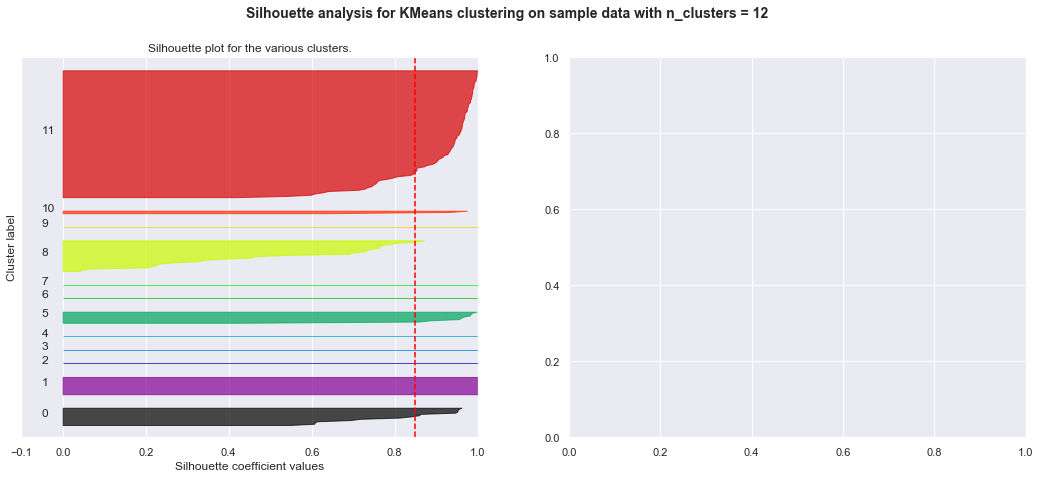

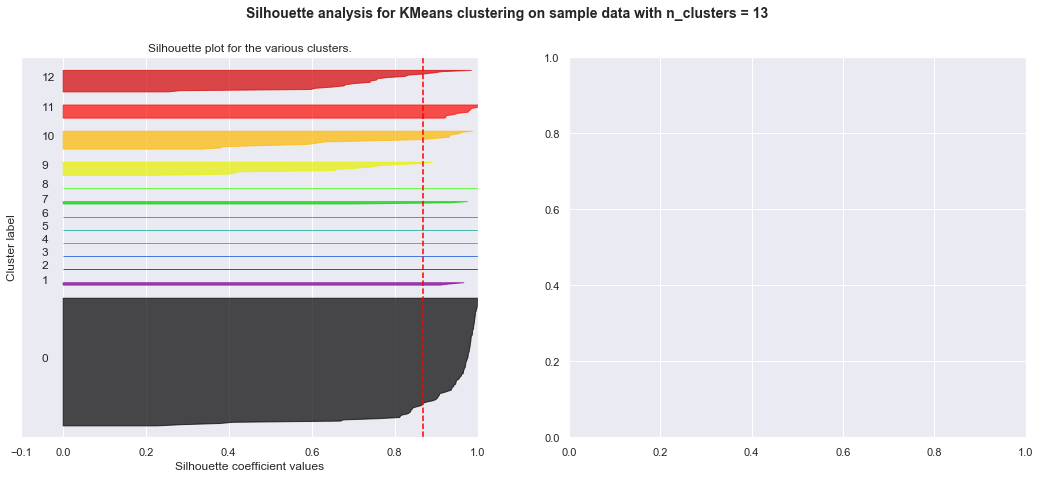

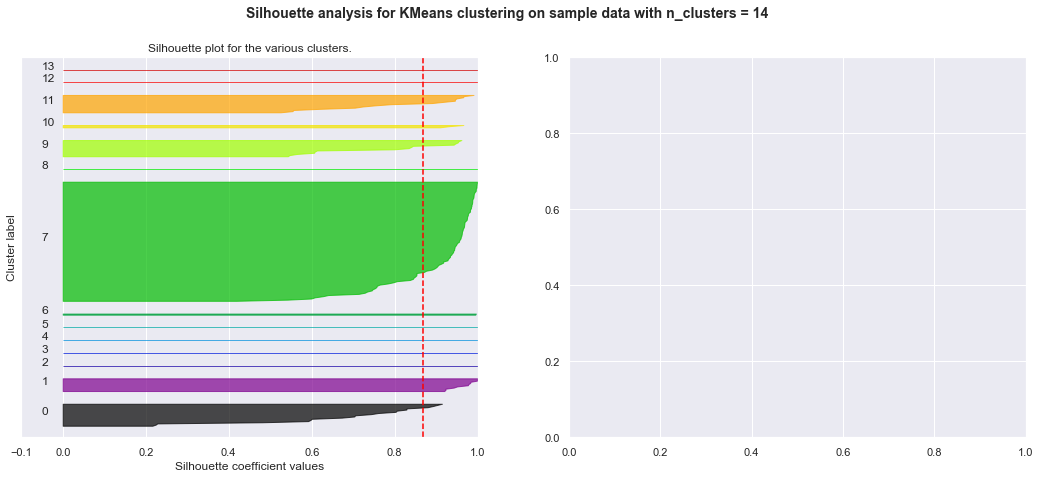

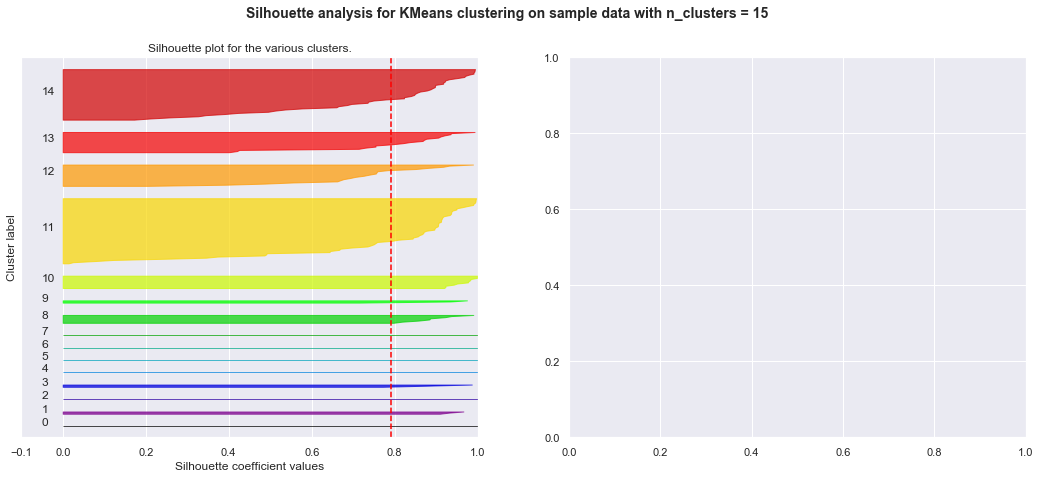

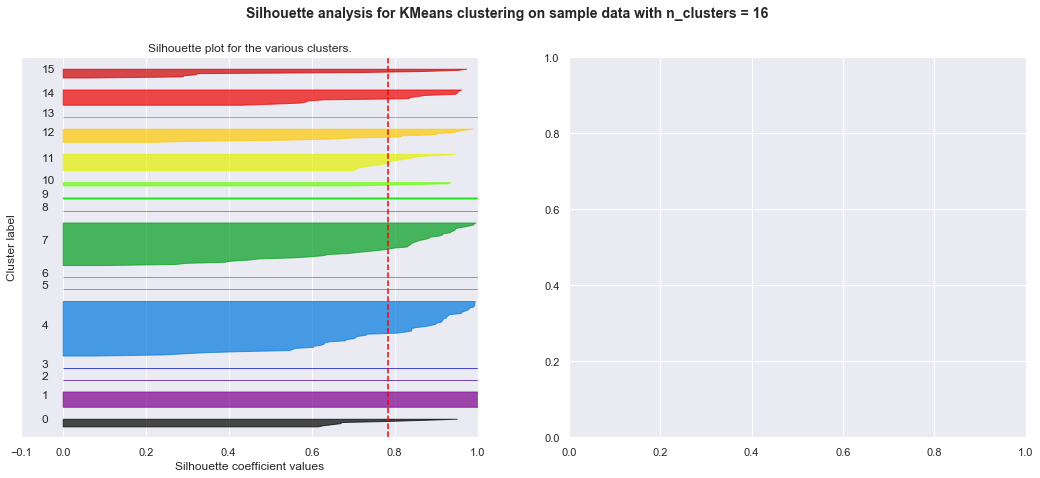

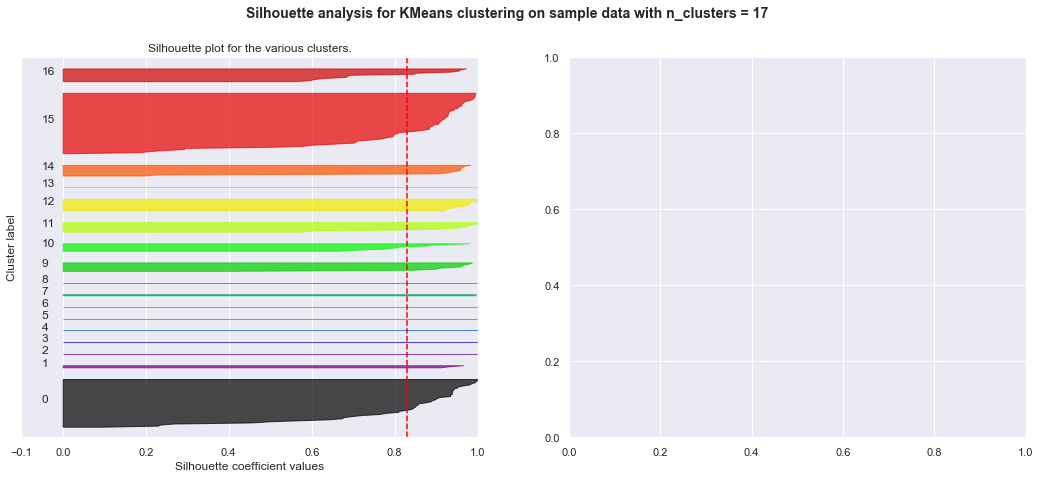

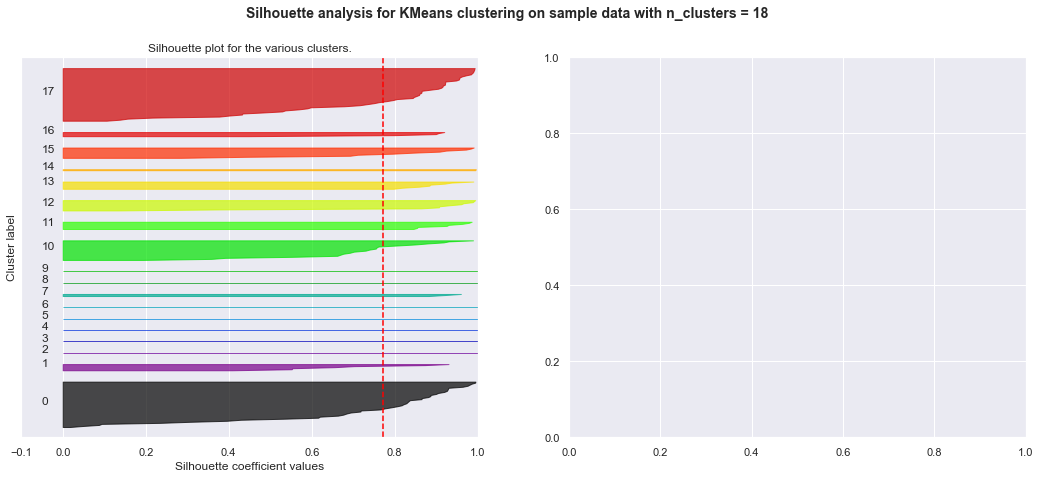

In [98]:
# get range of k values tested
k_range = %sql SELECT k FROM k_auto ORDER BY k;

# outer loop on k
# plot clusters for each k value
for n_clusters in k_range:
    
    # create table mapping each point to its centroid
    kval = n_clusters[0]
    %sql DROP TABLE IF EXISTS k_plot1;
    %sql CREATE TABLE k_plot1 AS (SELECT data.*, (madlib.closest_column(centroids, feature_vector, 'madlib.squared_dist_norm2')).column_id as cluster_id FROM training_data_work2 as data, k_auto WHERE k=$kval);

    # get info from tables and reshape to np arrays    
    # number of points
    num_points_proxy= %sql SELECT COUNT(*) FROM k_plot1;
    num_points= num_points_proxy[0][0]
    
    # points
    points_proxy = %sql SELECT feature_vector FROM k_plot1 ORDER BY pid;
    points = np.array(points_proxy).reshape(num_points,123) 
    
    # cluster id
    cluster_id_proxy = %sql SELECT cluster_id FROM k_plot1 ORDER BY pid;
    cluster_id = np.array(cluster_id_proxy).reshape(num_points)
    
    # centroids
    centroids_proxy = %sql SELECT centroids FROM k_auto WHERE k=$kval;
    centers = np.array(centroids_proxy[0][0]).reshape(kval,123)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = %sql SELECT silhouette FROM k_auto WHERE k=$kval;
    print("For n_clusters =", kval,
          "The average silhouette_score is :", silhouette_avg)
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
      
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    len_X = %sql select count(*) from training_data_work2;
    len_X = len_X[0][0]
    ax1.set_ylim([0, len_X + (kval + 1) * 10])
    
    y_lower = 10
    
    # inner loop on number of centroids 
    for i in range(kval):

        %sql DROP TABLE IF EXISTS points_distr1;
        %sql SELECT * FROM madlib.simple_silhouette_points( 'training_data_work2', 'points_distr1', 'pid', 'feature_vector', (SELECT centroids FROM k_auto WHERE k=$kval), 'madlib.squared_dist_norm2');
        ith_cluster_silhouette_values_proxy = %sql SELECT silh from points_distr1 WHERE centroid_id=$i ORDER BY silh;
        ith_cluster_silhouette_values = np.array(ith_cluster_silhouette_values_proxy).reshape(len(ith_cluster_silhouette_values_proxy))
        
        size_cluster_i_proxy = %sql SELECT COUNT(*) from points_distr1 WHERE centroid_id=$i;
        size_cluster_i = size_cluster_i_proxy[0][0]

        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / kval)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 
                  0, ith_cluster_silhouette_values, 
                  facecolor=color, edgecolor=color, alpha=0.7);
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i));

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
           
    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    centroids = %sql SELECT centroid_id FROM points_distr1 ORDER BY pid;
    cluster_labels = np.array(centroids).reshape(len(centroids))
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / kval)
    #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
    #            c=colors, edgecolor='k')

    # Labeling the clusters
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')

    #ax2.set_title("Visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % kval),
                 fontsize=14, fontweight='bold')

plt.show();

Profiles above show decision boundary to be overlapping and centroid=15 is not better than others really.  We can aggregate the view to confirm (higher silh value is better):

7 rows affected.
7 rows affected.


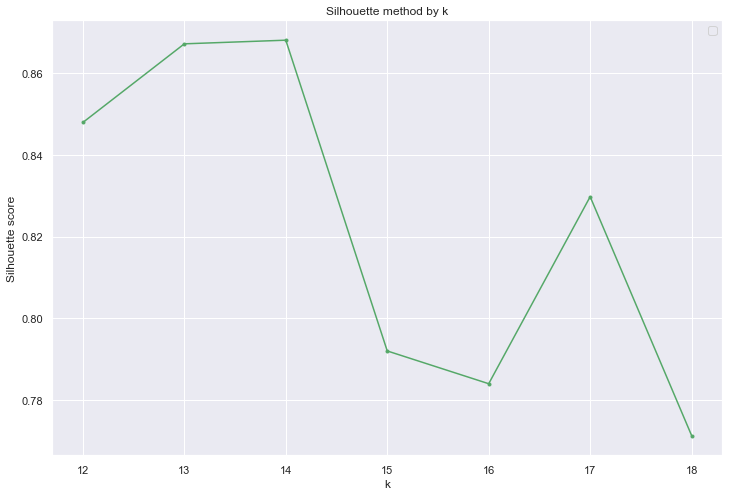

In [100]:
# get silhouette values for each k
k = %sql SELECT k FROM k_auto ORDER BY k;
silhouette = %sql SELECT silhouette FROM k_auto ORDER BY k;

#plot
plt.title('Silhouette method by k');
plt.xlabel('k');
plt.ylabel('Silhouette score');
plt.grid(True,);
plt.plot(k, silhouette, 'g.-');
plt.legend();

But the elbow method does show 15 to be the best number of centroids (bigger elbow value is better)

7 rows affected.


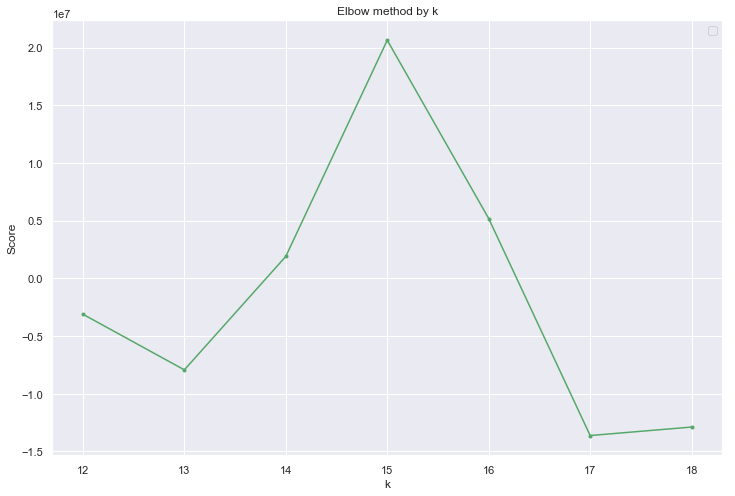

In [105]:
# get elbow values for each k
elbow = %sql SELECT elbow FROM k_auto ORDER BY k;

#plot
plt.title('Elbow method by k');
plt.xlabel('k');
plt.ylabel('Score');
plt.grid(True,);
plt.plot(k, elbow, 'g.-');
plt.legend();

<a id="feature_eng"></a>

## Feature Engineering

We tried several variations on the sampling theme but only 1 is show below: undersample classes with more than 1000 examples down to 1000, and sample the rest to 100.  Other more complex schemes like stratified sampling did not seem to yield better results.

In [24]:
%sql SET search_path=network_anomaly_run2,madlib

Done.


[]

Extract classes with > 1000 examples:

In [9]:
%%sql 
DROP TABLE IF EXISTS y;
CREATE TABLE y AS SELECT y, (COUNT(*)>=1000) AS is_top FROM public.training_data GROUP BY y;

Done.
23 rows affected.


[]

In [10]:
%%sql DROP TABLE IF EXISTS training_data_top;
CREATE TABLE training_data_top AS
    SELECT *
FROM public.training_data JOIN y USING(y) WHERE is_top=TRUE;
SELECT COUNT(*) FROM training_data_top

Done.
4897009 rows affected.
1 rows affected.


count
4897009


Extract classes with < 1000 examples:

In [11]:
%%sql DROP TABLE IF EXISTS training_data_bottom;
CREATE TABLE training_data_bottom AS
    SELECT *
FROM public.training_data JOIN y USING(y) WHERE is_top=FALSE;
SELECT COUNT(*) FROM training_data_bottom

Done.
1422 rows affected.
1 rows affected.


count
1422


Undersample majority 9 classes to 1000 each:

In [12]:
%%sql
DROP TABLE IF EXISTS training_data_top_sample2;
SELECT madlib.balance_sample(
                              'training_data_top',              -- Source table
                              'training_data_top_sample2',      -- Output table
                              'y',                 -- Class column
                              'uniform',           -- Uniform sample
                               9000);              -- Desired output table size

Done.
1 rows affected.


balance_sample
""


In [13]:
%sql SELECT y, COUNT(*) FROM training_data_top_sample2 GROUP BY y;

9 rows affected.


y,count
class06,1000
class11,1000
class15,1000
class17,1000
class01,1000
class10,1000
class18,1000
class21,1000
normal,1000


In [14]:
%%sql
DROP TABLE IF EXISTS training_data_bottom_sample2;
SELECT madlib.balance_sample(
                              'training_data_bottom',              -- Source table
                              'training_data_bottom_sample2',      -- Output table
                              'y',                 -- Class column
                              'uniform',           -- Uniform sample
                               1400);              -- Desired output table size

Done.
1 rows affected.


balance_sample
""


In [15]:
%sql SELECT y, COUNT(*) FROM training_data_bottom_sample2 GROUP BY y;

14 rows affected.


y,count
class03,100
class05,100
class07,100
class09,100
class12,100
class14,100
class16,100
class02,100
class04,100
class08,100


Now UNION them and check results:

In [16]:
%%sql
    DROP TABLE IF EXISTS training_data_balanced2;
    CREATE TABLE training_data_balanced2 AS
    SELECT * FROM training_data_top_sample2 UNION SELECT * FROM training_data_bottom_sample2;

Done.
10400 rows affected.


[]

In [18]:
%sql SELECT y,count(*) FROM training_data_balanced2 GROUP BY y ORDER BY y;

23 rows affected.


y,count
class01,1000
class02,100
class03,100
class04,100
class05,100
class06,1000
class07,100
class08,100
class09,100
class10,1000


In [19]:
%sql ALTER TABLE training_data_balanced2 DROP COLUMN is_top;

Done.


[]

Create test/train split on 80/20 basis:

In [20]:
%%sql
DROP TABLE IF EXISTS balanced2_train, balanced2_test;
SELECT madlib.train_test_split(
                                'training_data_balanced2',    -- Source table
                                'balanced2',            -- Output table
                                0.8,       -- Sample proportion
                                NULL,       -- Sample proportion
                                NULL,       -- Strata definition
                                NULL,       -- Columns to output
                                FALSE,     -- Sample without replacement
                                TRUE);    -- Do not separate output tables
SELECT y,COUNT(*) FROM balanced2_train GROUP BY y;

Done.
1 rows affected.
23 rows affected.


y,count
class01,788
class03,83
class05,87
class07,83
class09,85
class10,801
class12,84
class14,83
class16,83
class18,821


<a id="#tag"></a>

In [21]:
%sql SELECT y,COUNT(*) FROM balanced2_test GROUP BY y;

23 rows affected.


y,count
class02,27
class04,15
class06,216
class08,15
class11,214
class13,26
class15,229
class17,180
class19,23
class20,25


### Train model with Random Forest
<a id="rf_train_model"></a>
https://madlib.apache.org/docs/latest/group__grp__random__forest.html

In [22]:
%sql ALTER TABLE balanced2_train DROP COLUMN __madlib_id__;

Done.


[]

In [23]:
%sql ALTER TABLE balanced2_test DROP COLUMN __madlib_id__;

Done.


[]

In [24]:
%%sql
DROP TABLE IF EXISTS rf_model2, rf_model2_summary, rf_model2_group;
SELECT madlib.forest_train(
            'balanced2_train',  -- source table
            'rf_model2',              -- output table
            'id',                     -- unique row id
            'y',                      -- dependent var
            '*',                      -- indep var
            null,                     -- cols to exclude
            null,                     -- grouping
            10::integer,              -- num trees
            5::integer,               -- num random features
            true::boolean,            -- importance
            5::integer,               -- num permutations
            10::integer,              -- max tree depth
            3::integer,               -- min split
            1::integer,               -- min bucket
            10::integer,               -- num splits
            NULL,                     -- null handling
            TRUE                      -- verbose
        );

Done.
1 rows affected.


forest_train
""


In [25]:
%%sql
    SELECT gid, sample_id
    FROM rf_model2;

10 rows affected.


gid,sample_id
1,1
1,2
1,3
1,4
1,5
1,6
1,7
1,8
1,9
1,10


<a id="rf_variable_importance"></a>
#### Variable Importance

Impurity importance:

,feature_name,impurity_feature_importance,oob_feature_importance
0,a4,1.597629,0.046803
1,a2,1.321560,0.034117
2,a23,0.968556,0.037731
3,a19,0.831987,0.033349
4,a17,0.741452,0.048955
5,a33,0.726509,0.044693
6,a40,0.679008,0.055408
7,a36,0.663073,0.014740
8,a35,0.648912,0.010236
9,a5,0.586486,0.038223


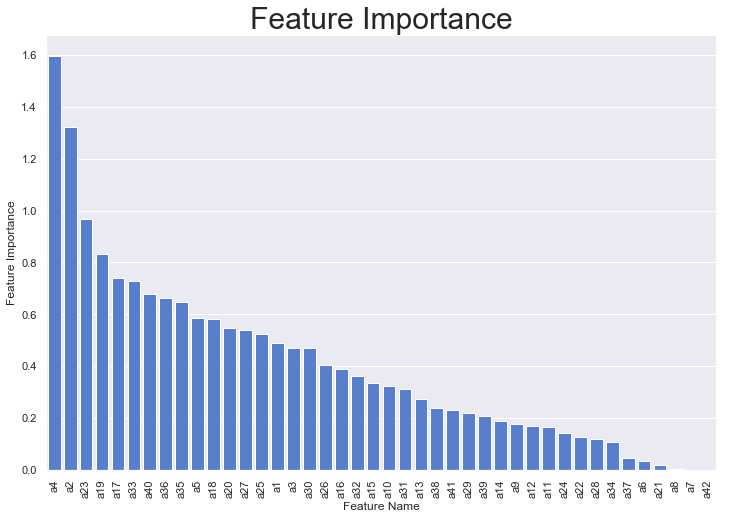

In [25]:
query = """SET search_path=network_anomaly_run2, madlib;
    SELECT unnest(string_to_array(independent_varnames,',')) AS feature_name
          ,unnest(impurity_var_importance) AS impurity_feature_importance
          ,unnest(oob_var_importance) AS oob_feature_importance
    FROM rf_model2_group l
        ,rf_model2_summary r
    ORDER BY 2 DESC
"""

df = query_gpdb(query)
ipd.display(df.head(10))
bar_plot(df,"Feature Importance","feature_name",'Feature Name',"impurity_feature_importance","Feature Importance", "#4378E2")

out of bag importance:

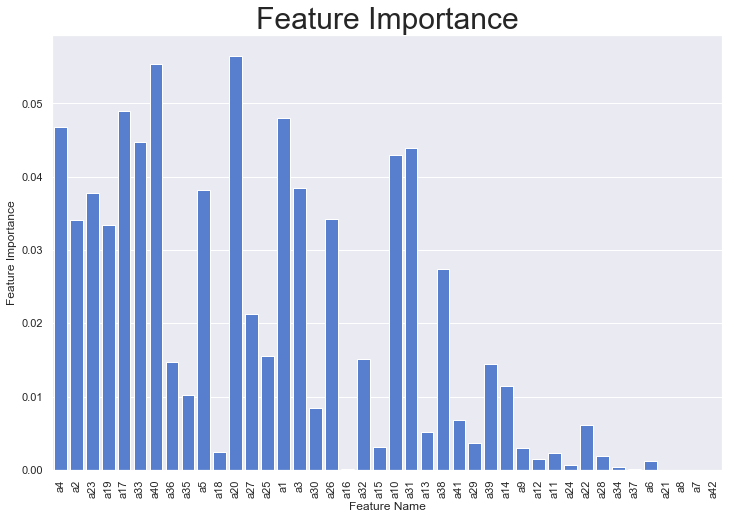

In [26]:
bar_plot(df,"Feature Importance","feature_name",'Feature Name',"oob_feature_importance","Feature Importance", "#4378E2")

<a id="rf_score_out_of_sample"></a>
#### Score Validation/Training Data

https://madlib.apache.org/docs/latest/group__grp__random__forest.html

In [27]:
# Evaluate validation dataset
query = """
    SET search_path=network_anomaly_run2,madlib;
    DROP TABLE IF EXISTS rf_model2_scored;
    SELECT madlib.forest_predict('rf_model2',
                                 'balanced2_test',
                                 'rf_model2_scored',
                                 'response');
                
    DROP TABLE IF EXISTS rf_model2_scored_tmp;
    CREATE TABLE rf_model2_scored_tmp AS
    SELECT *
    FROM rf_model2_scored
    JOIN balanced2_test
    USING (id);
    DROP TABLE rf_model2_scored;
    ALTER TABLE rf_model2_scored_tmp RENAME TO rf_model2_scored;
    SELECT * FROM rf_model2_scored LIMIT 10;
    
"""
cur.execute(query)

In [ ]:
# Evaluate training dataset
query = """
    DROP TABLE IF EXISTS rf_model4_scored;
    SELECT madlib.forest_predict('rf_model4',
                                 'balanced4_train',
                                 'rf_model4_scored',
                                 'response');
                
    DROP TABLE IF EXISTS rf_model4_scored_tmp;
    CREATE TABLE rf_model4_scored_tmp AS
    SELECT *
    FROM rf_model4_scored
    JOIN balanced4_train
    USING (id);
    DROP TABLE rf_model4_scored;
    ALTER TABLE rf_model4_scored_tmp RENAME TO rf_model4_scored;
    SELECT * FROM rf_model4_scored LIMIT 10;
    
"""
cur.execute(query)

In [27]:
# Evaluate on entire 4.9-million "training" dataset
query = """
    DROP TABLE IF EXISTS rf_model2_scored;
    SELECT madlib.forest_predict('rf_model2',
                                 'public.training_data',
                                 'rf_model2_scored',
                                 'response');
                
    DROP TABLE IF EXISTS rf_model2_scored_tmp;
    CREATE TABLE rf_model2_scored_tmp AS
    SELECT *
    FROM rf_model2_scored
    JOIN public.training_data
    USING (id);
    DROP TABLE rf_model2_scored;
    ALTER TABLE rf_model2_scored_tmp RENAME TO rf_model2_scored;
    SELECT * FROM rf_model2_scored LIMIT 10;
    
"""
cur.execute(query)

In [31]:
# Evaluate on 311K "eval" dataset
query = """
    SET search_path=network_anomaly_run2,madlib;
    DROP TABLE IF EXISTS rf_model2_scored;
    SELECT madlib.forest_predict('rf_model2',
                                 'public.eval_data',
                                 'rf_model2_scored',
                                 'response');
                
    DROP TABLE IF EXISTS rf_model2_scored_tmp;
    CREATE TABLE rf_model2_scored_tmp AS
    SELECT *
    FROM rf_model2_scored
    JOIN public.eval_data
    USING (id);
    DROP TABLE rf_model2_scored;
    ALTER TABLE rf_model2_scored_tmp RENAME TO rf_model2_scored;
    SELECT * FROM rf_model2_scored LIMIT 10;
    
"""
cur.execute(query)

In [36]:
%config SqlMagic.autopandas=True

In [34]:
%%sql
select * from rf_model2_scored order by id limit 10;

10 rows affected.


,id,estimated_y,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39,a40,a41,a42
0,0,class18,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1328.0,1.00,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0
1,1,normal,TCP,HTTP,STAT10,280.0,3413.0,0,0,0,0,1,0,0.0,0.0,1.0,0,674.0,0.04,0.0,0.0,26.0,0.0,0.0,251.0,0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,1.0,0.0,26.0,0.0,0.0,0.0,0.0,26.0,0.0,0
2,2,normal,TCP,HTTP,STAT10,218.0,1493.0,0,0,0,0,1,0,0.0,0.0,1.0,0,990.0,0.01,0.0,0.0,9.0,0.0,0.0,255.0,0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,129.0,0.0,0.0,0.0,0.0,9.0,0.0,0
3,3,class18,ICMP,ECR_I,STAT10,520.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1178.0,1.00,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0
4,4,class18,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1554.0,1.00,0.0,0.0,510.0,0.0,0.0,255.0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,510.0,0.0,0
5,5,class18,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1233.0,1.00,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0
6,6,normal,UDP,PRIVATE,STAT10,42.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,1695.0,0.01,0.0,0.0,3.0,0.0,0.0,255.0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,3.0,0.0,0
7,7,normal,TCP,HTTP,STAT10,305.0,1846.0,0,0,0,0,1,0,0.0,0.4,1.0,0,1289.0,0.12,0.0,0.0,5.0,0.0,0.0,255.0,0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,4.0,0.0,0
8,8,class18,ICMP,ECR_I,STAT10,1032.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,989.0,1.00,0.0,0.0,511.0,0.0,0.0,255.0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,511.0,0.0,0
9,9,class18,ICMP,ECR_I,STAT10,520.0,0.0,0,0,0,0,0,0,0.0,0.0,1.0,0,766.0,1.00,0.0,0.0,476.0,0.0,0.0,255.0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,255.0,0.0,0.0,0.0,0.0,476.0,0.0,0


In [ ]:
%%sql 
SET search_path=network_anomaly_run2, madlib;

<a id="confusion"></a>
#### Confusion matrix:

In [30]:
%%sql
DROP TABLE IF EXISTS confusion;
SELECT madlib.confusion_matrix( 'rf_model2_scored', 'confusion', 'estimated_y', 'y');
SELECT * FROM confusion ORDER BY "class";

Done.
1 rows affected.
23 rows affected.


,row_id,class,confusion_arr
0,1,class01,"[2202, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,2,class02,"[0, 25, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
2,3,class03,"[0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
3,4,class04,"[0, 0, 0, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,5,class05,"[0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,6,class06,"[0, 0, 0, 0, 0, 12447, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1, 5, 0, 0, 0, 0, 0, 21]"
6,7,class07,"[0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,8,class08,"[0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,9,class09,"[0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0]"
9,10,class10,"[0, 0, 0, 0, 108, 0, 108, 0, 0, 1060156, 11, 0, 0, 0, 11247, 0, 256, 0, 1, 0, 0, 0, 130]"


In [28]:
%%sql DROP TABLE IF EXISTS accuracy_by_class;
CREATE TABLE accuracy_by_class AS
    SELECT y,correct, total,correct::FLOAT/total as accuracy
FROM (SELECT y, COUNT(*) AS correct FROM rf_model2_scored WHERE y=estimated_y GROUP BY y) c JOIN
     (SELECT y,count(*) AS total FROM rf_model2_scored GROUP BY y) t USING(y);
SELECT * FROM accuracy_by_class ORDER BY y;

Done.
23 rows affected.
23 rows affected.


y,correct,total,accuracy
class01,212,212,1.0
class02,20,27,0.740740740741
class03,7,17,0.411764705882
class04,15,15,1.0
class05,11,13,0.846153846154
class06,211,216,0.976851851852
class07,17,17,1.0
class08,15,15,1.0
class09,1,15,0.0666666666667
class10,192,199,0.964824120603


In [29]:
%sql SELECT AVG(accuracy) AS balanced_accuracy FROM accuracy_by_class;

1 rows affected.


balanced_accuracy
0.900378370374


This is overfitting ^^^ likely

<a id="write"></a>
### CSV output for submission

In [37]:
eval_result = %sql select id as "ID", estimated_y as "ANOMALY" from rf_model2_scored order by ID;

311030 rows affected.


In [38]:
eval_result[:5]

,ID,ANOMALY
0,0,class18
1,1,normal
2,2,normal
3,3,class18
4,4,class18


Write out eval dataset results to CSV to submit:

In [39]:
eval_result.to_csv("/Users/fmcquillan/Downloads/eval_result_run2.csv")

Done for now!